# Imports

In [1]:
import math

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
def set_seed():
    seed = 42
    torch.manual_seed(seed)

set_seed()

In [3]:
batch_size=128

# Beeg data

In [4]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_test = torch.Tensor( testset.data ) / 255.0# - 0.5
y_test = torch.Tensor( testset.targets ).long()
X_train = torch.Tensor( trainset.data ) / 255.0# - 0.5
y_train = torch.Tensor( trainset.targets ).long()

# train_dataset = TensorDataset(X_train, y_train)

train_data = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

# MAchibe learnin

In [ ]:
n_expansion = 64
n_latent = 64
n_channels = 1

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_latent, out_channels=n_expansion*8, kernel_size=4, stride=1, bias=True),
            nn.BatchNorm2d(n_expansion*8),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*8, out_channels=n_expansion*4, kernel_size=4, stride=2, bias=True),
            nn.BatchNorm2d(n_expansion*4),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*4, out_channels=n_expansion*2, kernel_size=4, stride=2, bias=True),
            nn.BatchNorm2d(n_expansion*2),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*2, out_channels=n_expansion, kernel_size=4, stride=1, bias=True),
            nn.BatchNorm2d(n_expansion),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion, out_channels=1, kernel_size=4, stride=1, bias=True),
            nn.Tanh(),
        )

    def forward(self, X):
        return self.layers(X)
    
def generate_samples(batch_size=256, device=device):
    return torch.randn((batch_size, n_latent, 1, 1), device=device)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_expansion, kernel_size=4, stride=1, padding=0, bias=True),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion, out_channels=n_expansion*2, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*2),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*2, out_channels=n_expansion*4, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*4),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*4, out_channels=n_expansion*8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*8),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  
        )

    def forward(self, X):
        return self.layers(X)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [185]:
def plot_samples(X_G):
    assert len(X_G.shape) == 4
    assert X_G.shape[1:] == (1, 28, 28), ValueError

    images = X_G.squeeze(1).detach().cpu().numpy()
    
    r, c = math.ceil(math.sqrt(X_G.shape[0])), math.floor(math.sqrt(X_G.shape[0]))
    fig, axes = plt.subplots(r, c, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray') 
        ax.axis('off')
    plt.show()

In [122]:
noise_samples = generate_samples(batch_size=16)

# Training

In [143]:
def train_gan(D, G, lr, tolerance, patience, lim, plot=False):
    loss_function = nn.BCELoss()
    
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    N_train = len(trainset)
    N_batches_train = N_train // batch_size

    optimizer_G = optim.Adam(G.parameters(), lr=lr)
    optimizer_D = optim.Adam(D.parameters(), lr=lr)

    G_progress = []
    batch_losses_G = []
    batch_losses_D = []
    epoch_losses_G = []
    epoch_losses_D = []
    for epoch in range(lim):
        epoch_loss_G = 0
        epoch_loss_D = 0
        for X_batch, _ in train_loader:
            # Train discriminator
            D.zero_grad()
            optimizer_D.zero_grad()

            X_batch_real = X_batch.to(device)
            y_batch_real = torch.zeros(X_batch.shape[0]).to(device)
            y_preds_real = D(X_batch_real).view(-1)

            noise = generate_samples(batch_size=batch_size)

            X_batch_fake = G(noise)
            y_batch_fake = torch.ones(batch_size).to(device)
            y_preds_fake = D(X_batch_fake.detach()).view(-1)

            y_batch = torch.cat([y_batch_real, y_batch_fake]).to(device)
            y_preds = torch.cat([y_preds_real, y_preds_fake]).to(device)

            loss_batch_D = loss_function(y_preds, y_batch)

            loss_batch_D.backward()
            optimizer_D.step()

            epoch_loss_D += loss_batch_D.item() / N_batches_train
            batch_losses_D.append(loss_batch_D.item())

            # Train generator

            G.zero_grad()
            
            y_true_G = torch.zeros(X_batch_fake.shape[0]).to(device)
            y_preds_G = D(X_batch_fake).view(-1)

            loss_batch_G = loss_function(y_preds_G, y_true_G)

            loss_batch_G.backward()
            optimizer_G.step()

            epoch_loss_G += loss_batch_G.item() / N_batches_train
            batch_losses_G.append(loss_batch_G.item())

        print(f"Epoch {epoch}  \tD: {epoch_loss_G}; G: {epoch_loss_D}")
        epoch_losses_D.append(epoch_loss_D)
        epoch_losses_G.append(epoch_loss_G)
        G_progress.append(G(noise_samples))

        if plot:
            plot_samples(G_progress[-1])

    return G_progress, (batch_losses_D, batch_losses_G), (epoch_losses_D, epoch_losses_G)


In [144]:
lr=.001
tolerance=.01
patience=10
lim=20
plot=True

hyperparams = {
    'lr': lr,
    'tolerance': tolerance,
    'patience': patience,
    'lim': lim,
    'plot': True,
}

In [145]:
# Create models
G = Generator().to(device)
D = Discriminator().to(device)

# Randomly initialize model weights
G.apply(weights_init)
D.apply(weights_init)

print(G)
print(D)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4

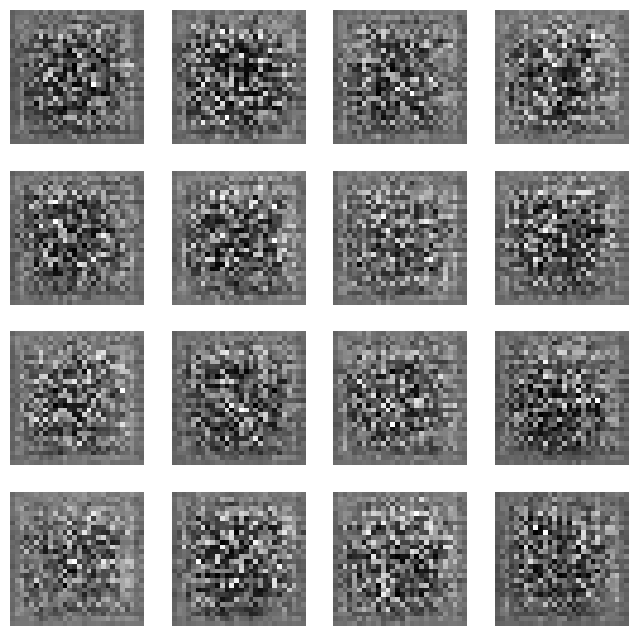

In [146]:
plot_samples(G(noise_samples))

Epoch 0  	D: 11.663781465246132; G: 0.15691812212567002


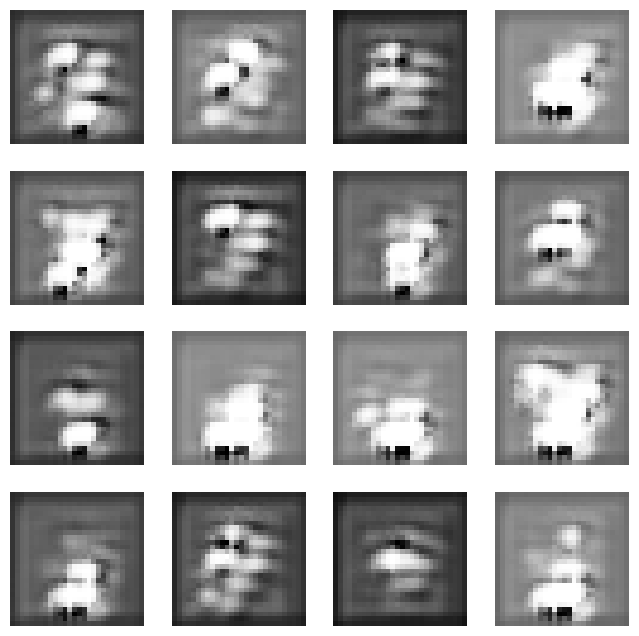

Epoch 1  	D: 8.38758064539005; G: 0.07068850513563574


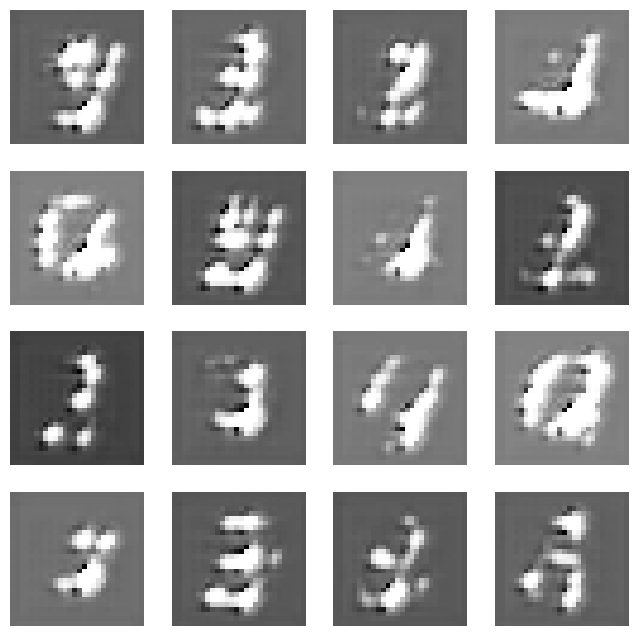

Epoch 2  	D: 10.355904249554007; G: 0.09310322904112915


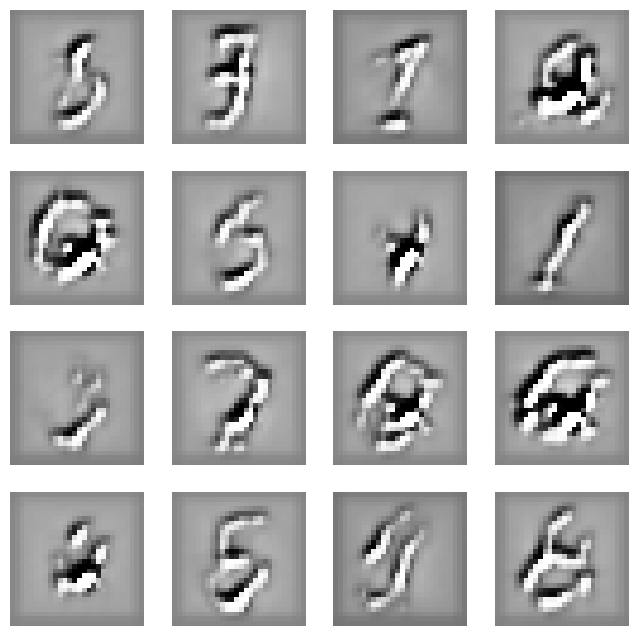

Epoch 3  	D: 15.946118787822572; G: 0.006535190355038155


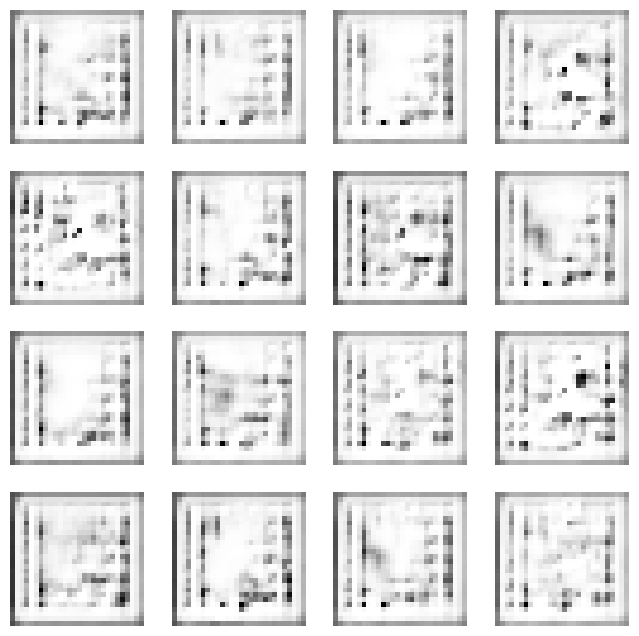

Epoch 4  	D: 15.01186499534509; G: 0.029774450120696072


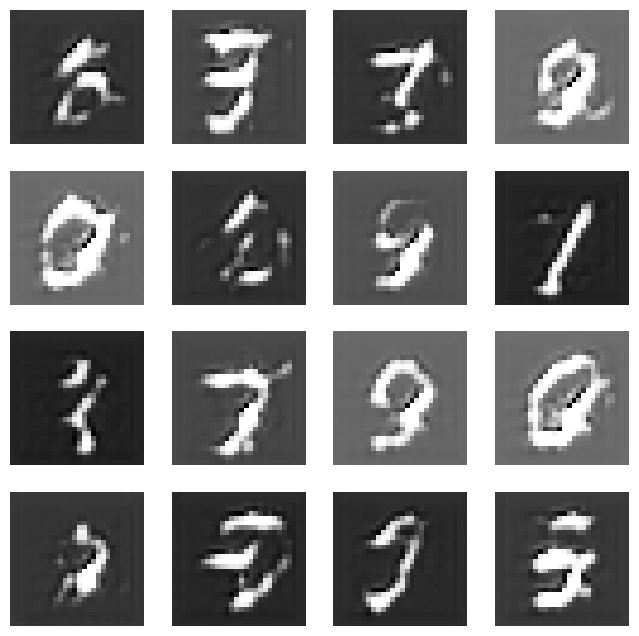

Epoch 5  	D: 9.55109791674167; G: 0.11791612870461891


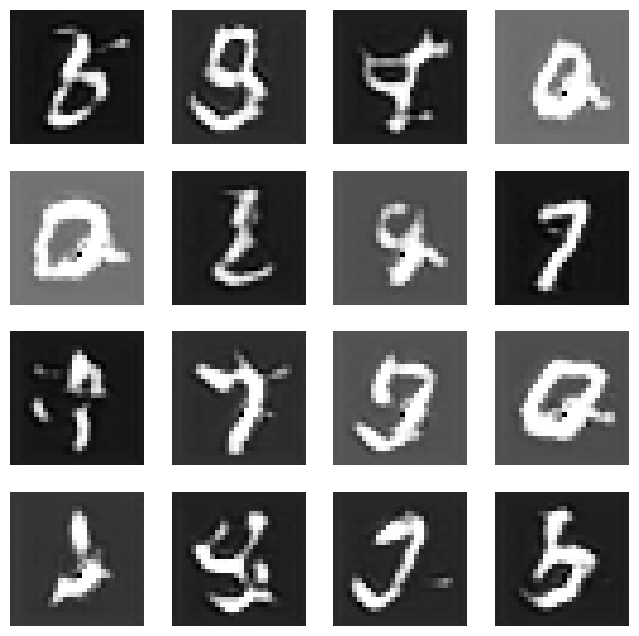

Epoch 6  	D: 6.986925276935615; G: 0.1711365700894408


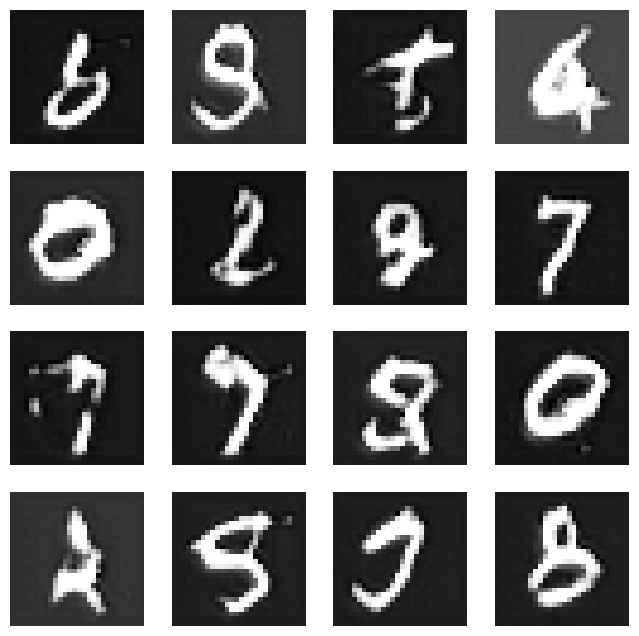

Epoch 7  	D: 5.038449849073703; G: 0.22388198636631423


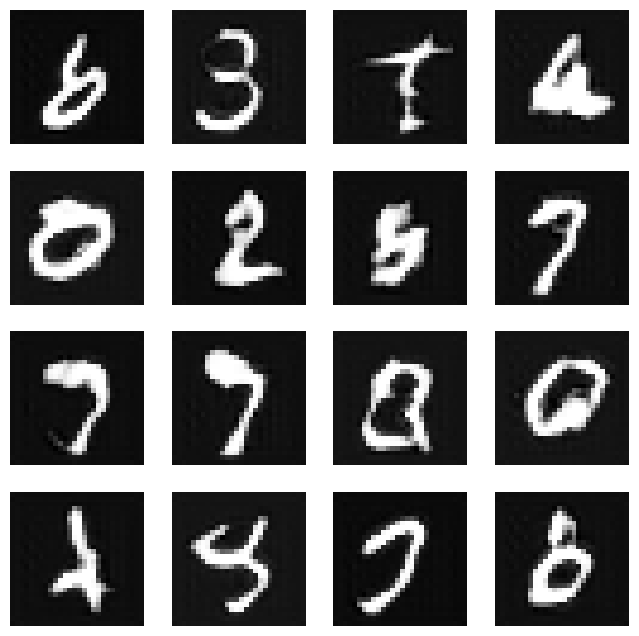

Epoch 8  	D: 4.900921718687074; G: 0.20483290591937856


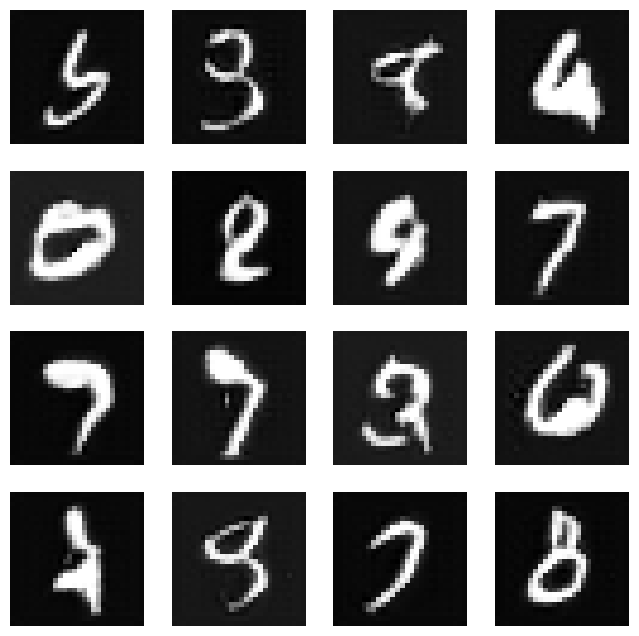

Epoch 9  	D: 4.964939159460557; G: 0.21080782388249397


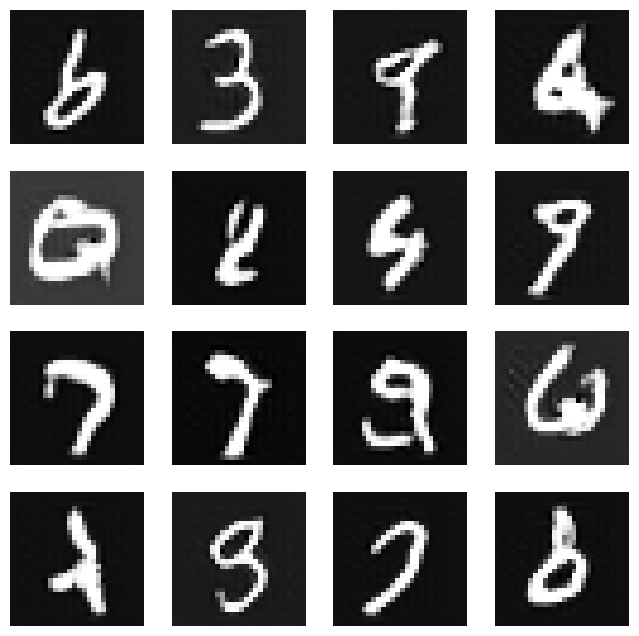

Epoch 10  	D: 4.496988092732224; G: 0.2200279928043358


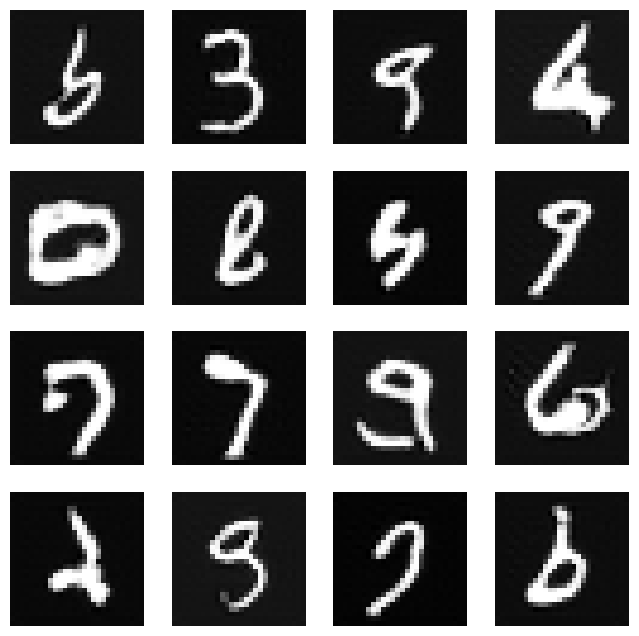

Epoch 11  	D: 4.026218283634919; G: 0.2713395328635078


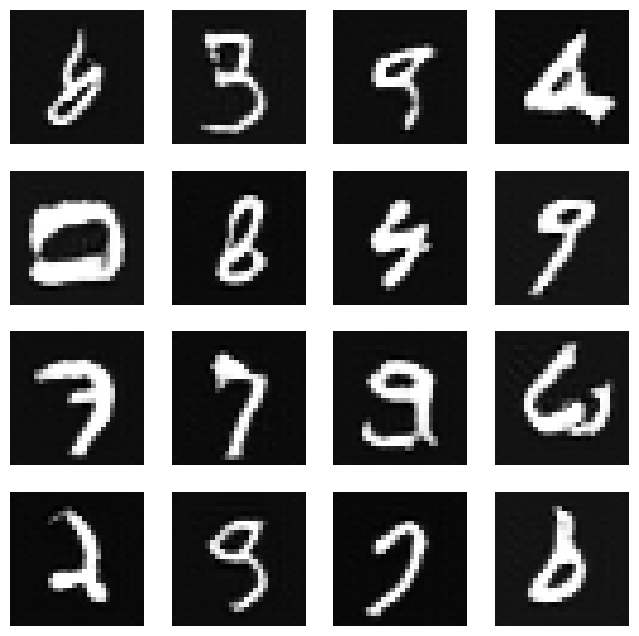

Epoch 12  	D: 4.025778703709955; G: 0.2595633179840879


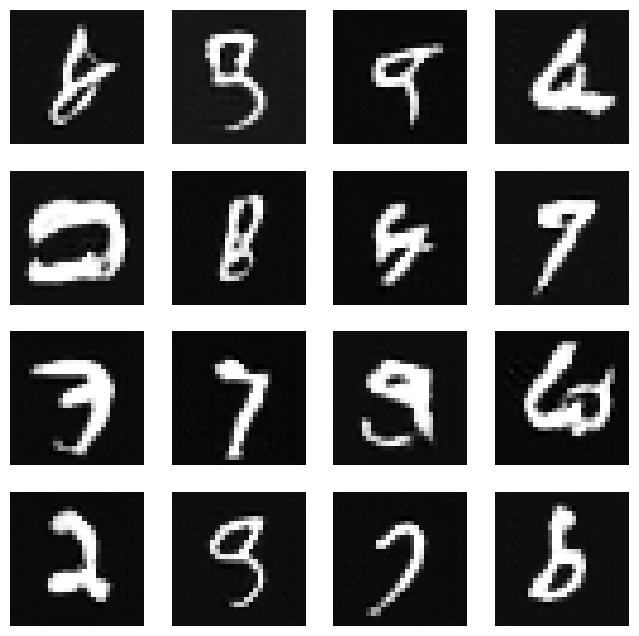

Epoch 13  	D: 4.26731347706583; G: 0.22307545764164766


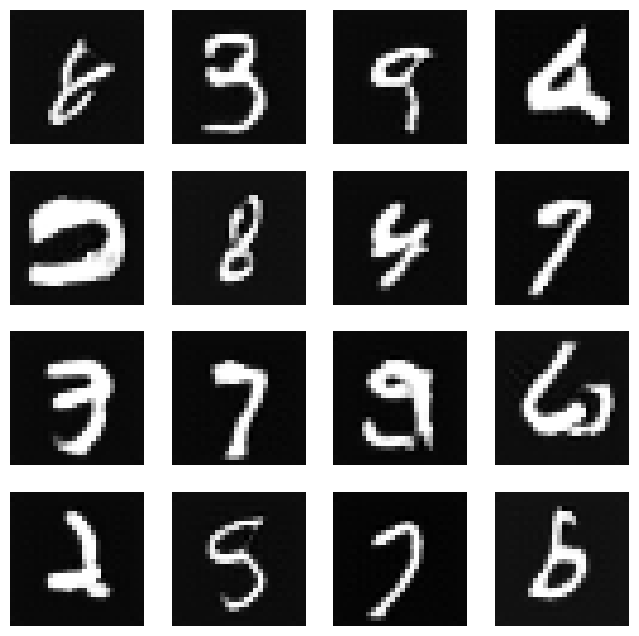

Epoch 14  	D: 4.287008417977226; G: 0.226978482813853


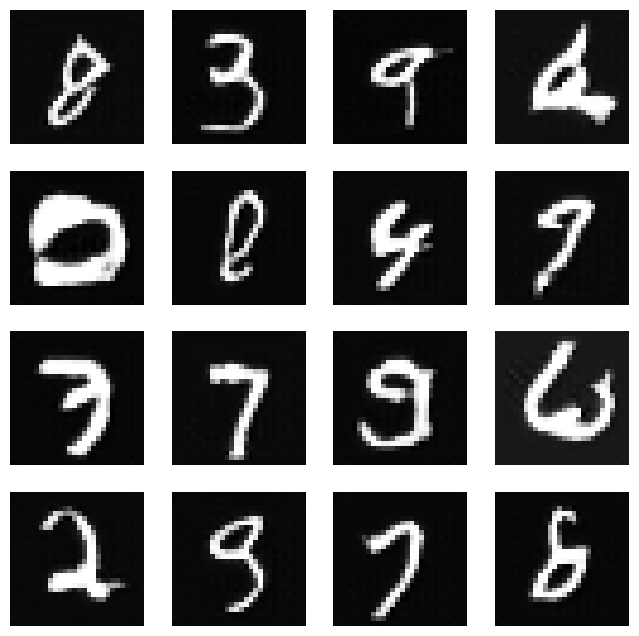

Epoch 15  	D: 4.039428310007112; G: 0.26114767731732563


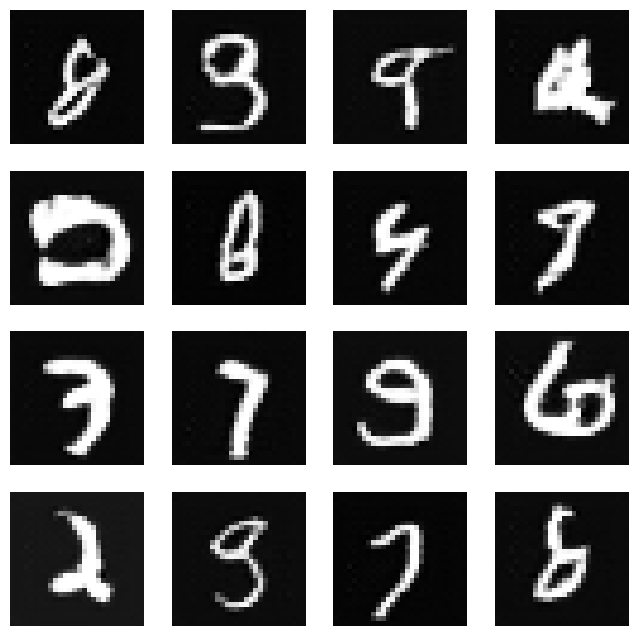

Epoch 16  	D: 4.054114298178599; G: 0.25006022732545685


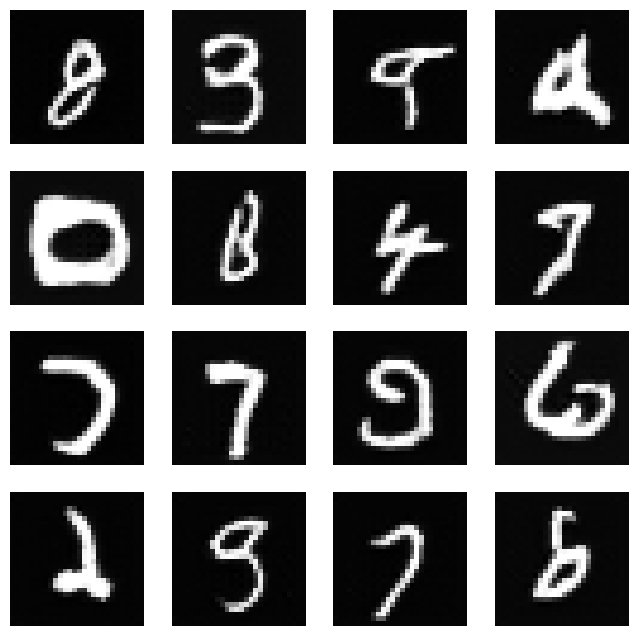

Epoch 17  	D: 4.137220239282672; G: 0.24660007619004476


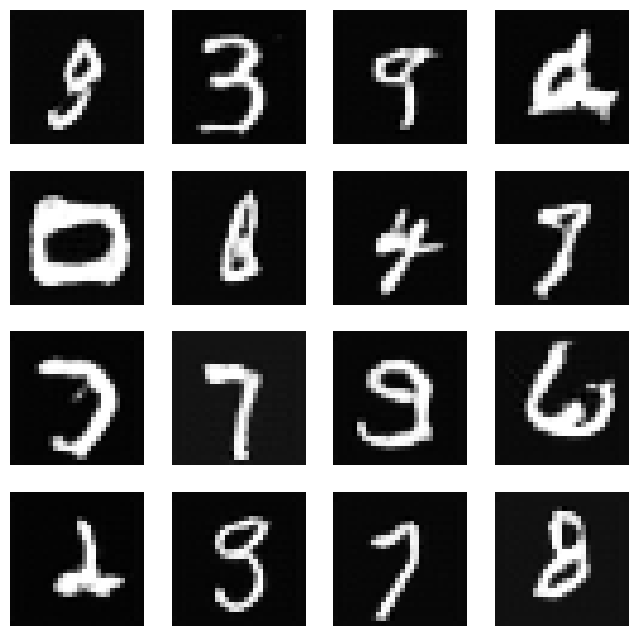

Epoch 18  	D: 4.294131736470081; G: 0.21179819113423656


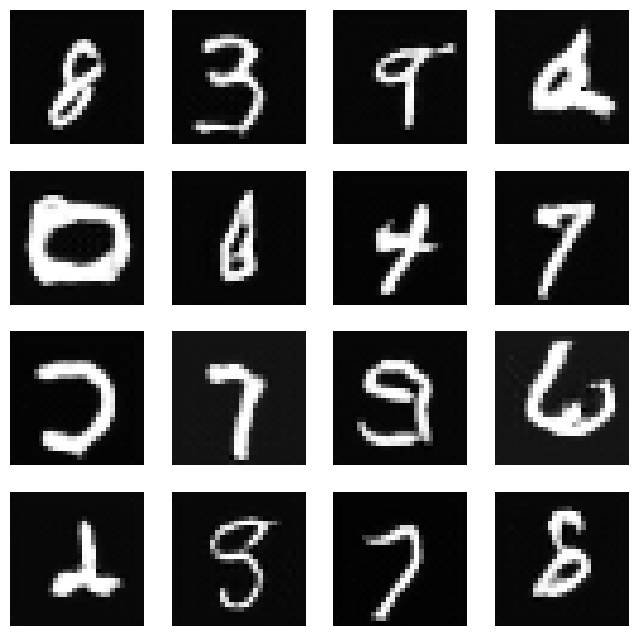

Epoch 19  	D: 4.193274212443929; G: 0.23800300501095922


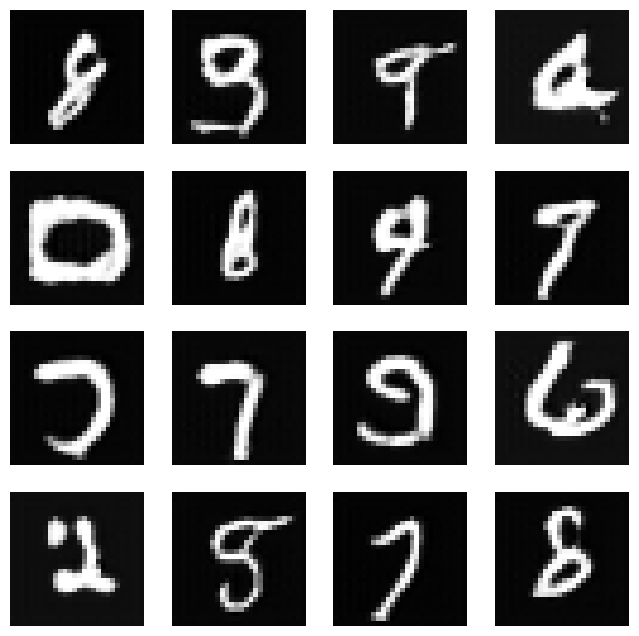

In [147]:
images, batch_losses, epoch_losses = train_gan(D, G, **hyperparams)

# Let's plot the loss!

### Batch losses

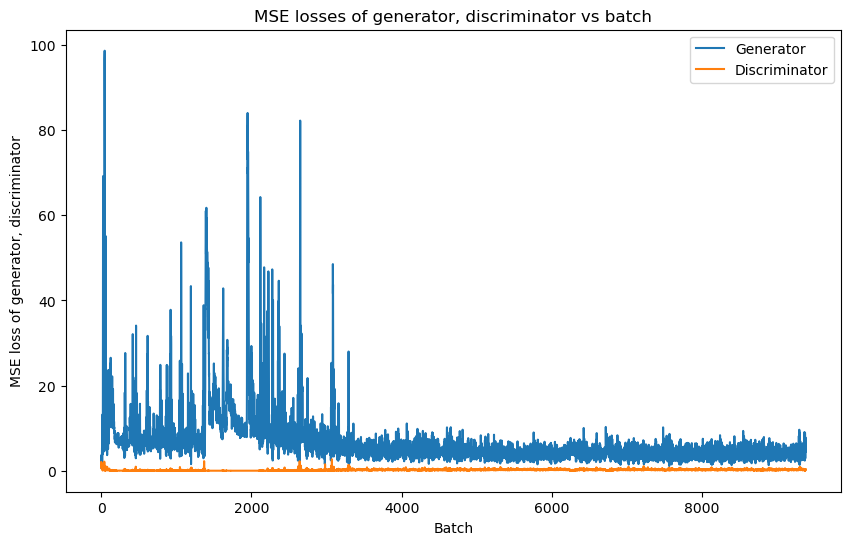

In [166]:
plt.figure(figsize=(10,6))

plt.plot(range(len(batch_losses[1])), batch_losses[1], label='Generator')
plt.plot(range(len(batch_losses[0])), batch_losses[0], label='Discriminator')

plt.xlabel('Batch')
plt.ylabel('MSE loss of generator, discriminator')
plt.title('MSE losses of generator, discriminator vs batch')

plt.legend()

plt.show()

### Epoch losses

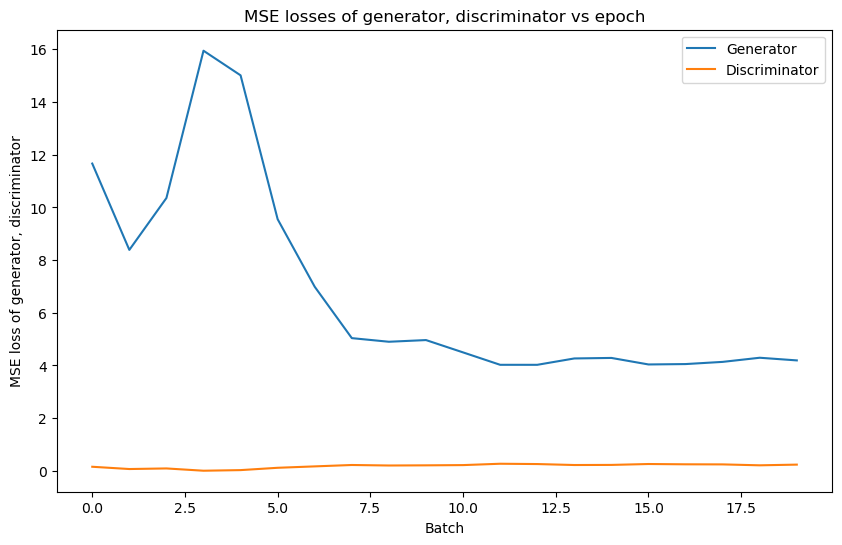

In [165]:
plt.figure(figsize=(10,6))

plt.plot(range(len(epoch_losses[1])), epoch_losses[1], label='Generator')
plt.plot(range(len(epoch_losses[0])), epoch_losses[0], label='Discriminator')

plt.xlabel('Batch')
plt.ylabel('MSE loss of generator, discriminator')
plt.title('MSE losses of generator, discriminator vs epoch')

plt.legend()

plt.show()

# Looking at some more images

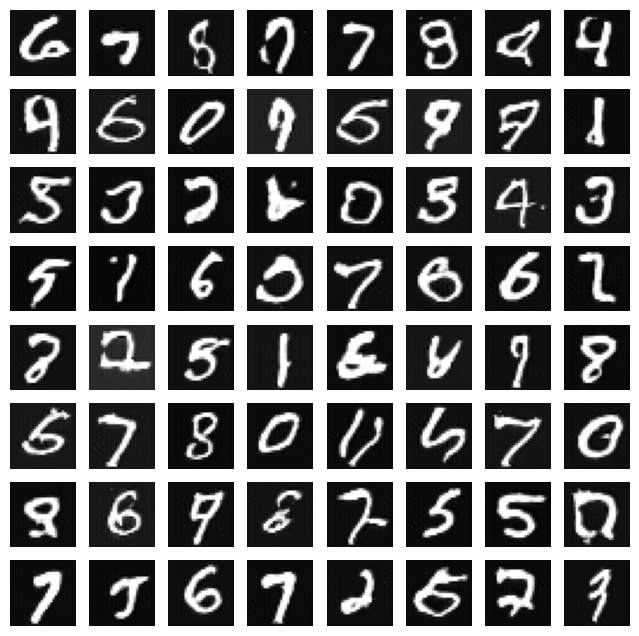

In [191]:
samples_images = G(generate_samples(64))
plot_samples(samples_images)

# Where to go from here?